In [42]:
from math import ceil
import json
import os
import sys

src_path = os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(src_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import visdom

from datasets import link_prediction
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator
import models
import utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
args = {
    "stats_per_batch" : 3,
    "dataset" : "CollegeMsg",
    "dataset_path" : "/Users/raunak/Documents/Datasets/temporal-networks-snap/CollegeMsg.txt",
    "mode" : "train",
    "neg_examples_path" : "/Users/raunak/Documents/Datasets/temporal-networks-snap/CollegeMsg_neg_examples_train.txt",
    "task" : "link_prediction",
    "agg_class" : "MaxPoolAggregator",
    "dropout" : 0.5,
    "cuda" : "True",
    "hidden_dims" : [64],
    "num_samples" : -1,
    "batch_size" : 32,
    "epochs" : 2,
    "lr" : 5e-4,
    "weight_decay" : 5e-4,
    
    "self_loop" : False,
    "normalize_adj" : False,
    
    "load" : False,
    "save" : False
}
config = args
config['num_layers'] = len(config['hidden_dims']) + 1


if config['cuda'] and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [3]:
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['neg_examples_path'], 'train',
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)

--------------------------------
Reading CollegeMsg dataset from /Users/raunak/Documents/Datasets/temporal-networks-snap/CollegeMsg.txt
Finished reading data.
Setting up data structures.
Finished setting up data structures.
Setting up examples.
Finished setting up examples.
--------------------------------


In [44]:
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=True, collate_fn=dataset.collate_wrapper)
input_dim, output_dim = dataset.get_dims()

In [45]:
agg_class = utils.get_agg_class(config['agg_class'])
model = models.GraphSAGE(input_dim, config['hidden_dims'], output_dim, config['dropout'],
                         agg_class, config['num_samples'], device)
model.to(device)

GraphSAGE(
  (aggregators): ModuleList(
    (0): MaxPoolAggregator(
      (fc1): Linear(in_features=1733, out_features=1733, bias=True)
      (relu): ReLU()
    )
    (1): MaxPoolAggregator(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (relu): ReLU()
    )
  )
  (fcs): ModuleList(
    (0): Linear(in_features=3466, out_features=64, bias=True)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5)
  (relu): ReLU()
)

In [46]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {}'.format(area))
    print('--------------------------------')

--------------------------------
Computing ROC-AUC score for the training dataset.
    Batch 1 / 248
    Batch 2 / 248
    Batch 3 / 248
    Batch 4 / 248
    Batch 5 / 248
    Batch 6 / 248
    Batch 7 / 248
    Batch 8 / 248
    Batch 9 / 248
    Batch 10 / 248
    Batch 11 / 248
    Batch 12 / 248
    Batch 13 / 248
    Batch 14 / 248
    Batch 15 / 248
    Batch 16 / 248
    Batch 17 / 248
    Batch 18 / 248
    Batch 19 / 248
    Batch 20 / 248
    Batch 21 / 248
    Batch 22 / 248
    Batch 23 / 248
    Batch 24 / 248
    Batch 25 / 248
    Batch 26 / 248
    Batch 27 / 248
    Batch 28 / 248
    Batch 29 / 248
    Batch 30 / 248
    Batch 31 / 248
    Batch 32 / 248
    Batch 33 / 248
    Batch 34 / 248
    Batch 35 / 248
    Batch 36 / 248
    Batch 37 / 248
    Batch 38 / 248
    Batch 39 / 248
    Batch 40 / 248
    Batch 41 / 248
    Batch 42 / 248
    Batch 43 / 248
    Batch 44 / 248
    Batch 45 / 248
    Batch 46 / 248
    Batch 47 / 248
    Batch 48 / 248
    Batch 49 /

In [47]:
if not config['load']:
    vis = visdom.Visdom()
    loss_window = None
    criterion = utils.get_criterion(config['task'])
    optimizer = optim.Adam(model.parameters(), lr=config['lr'],
                           weight_decay=config['weight_decay'])
    epochs = config['epochs']
    stats_per_batch = config['stats_per_batch']
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.8)
    model.train()
    print('--------------------------------')
    print('Training.')
    for epoch in range(epochs):
        print('Epoch {} / {}'.format(epoch+1, epochs))
        running_loss = 0.0
        # num_correct, num_examples = 0, 0
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            loss = criterion(scores, labels.float())
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                running_loss += loss.item()
                # predictions = (scores >= 0.5).long()
                # num_correct = torch.sum(predictions == labels.long()).item()
                # num_examples += len(labels)
            if (idx + 1) % stats_per_batch == 0:
                running_loss /= stats_per_batch
                # accuracy = num_correct / num_examples
                area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
                # print('    Batch {} / {}: loss {}, accuracy {}'.format(
                #     idx+1, num_batches, running_loss, accuracy))
                print('    Batch {} / {}: loss {}'.format(
                    idx+1, num_batches, running_loss))
                print('    ROC-AUC score: {}'.format(area))
                running_loss = 0.0
                num_correct, num_examples = 0, 0
            if loss_window is None:
                loss_window = vis.line(
                    Y=[loss.item()],
                    X=[epoch*num_batches+idx],
                    opts=dict(xlabel='batch', ylabel='Loss', title='Training Loss', legend=['Loss']))
            else:
                vis.line(
                    [loss.item()],
                    [epoch*num_batches+idx],
                    win=loss_window,
                    update='append')
            scheduler.step()
    vis.close(win=loss_window)
    print('Finished training.')
    print('--------------------------------')

--------------------------------
Training.
Epoch 1 / 2
    Batch 3 / 248: loss 0.6933706204096476
    ROC-AUC score: 0.42063492063492064
    Batch 6 / 248: loss 0.6928354303042094
    ROC-AUC score: 0.48235294117647065
    Batch 9 / 248: loss 0.6908673445383707
    ROC-AUC score: 0.6640625
    Batch 12 / 248: loss 0.6901973485946655
    ROC-AUC score: 0.7099567099567099
    Batch 15 / 248: loss 0.6898095806439718
    ROC-AUC score: 0.7686274509803922
    Batch 18 / 248: loss 0.6923949122428894
    ROC-AUC score: 0.5515873015873016
    Batch 21 / 248: loss 0.6905598441759745
    ROC-AUC score: 0.6431372549019608
    Batch 24 / 248: loss 0.6897528568903605
    ROC-AUC score: 0.6190476190476191
    Batch 27 / 248: loss 0.6875479420026144
    ROC-AUC score: 0.8097165991902835
    Batch 30 / 248: loss 0.6898790597915649
    ROC-AUC score: 0.6753246753246754
    Batch 33 / 248: loss 0.6861851414044698
    ROC-AUC score: 0.8218623481781376
    Batch 36 / 248: loss 0.6838402350743612
    ROC-A

KeyboardInterrupt: 

In [48]:
if not config['load']:
    config['save'] = True
    if config['save']:
        print('--------------------------------')
        directory = os.path.join(os.path.dirname(os.getcwd()),
                                'trained_models')
        if not os.path.exists(directory):
            os.makedirs(directory)
        fname = utils.get_fname(config)
        path = os.path.join(directory, fname)
        print('Saving model at {}'.format(path))
        torch.save(model.state_dict(), path)
        print('Finished saving model.')
        print('--------------------------------')

--------------------------------
Saving model at /Users/raunak/Documents/Projects/Temporal-Graph-Neural-Networks/trained_models/graphsage_agg_class_MaxPoolAggregator_hidden_dims_64_num_samples_-1_batch_size_32_epochs_2_lr_0.0005_weight_decay_0.0005.pth
Finished saving model.
--------------------------------


In [49]:
if not config['load']:
    print('--------------------------------')
    print('Computing ROC-AUC score for the training dataset.')
    y_true, y_scores = [], []
    num_batches = int(ceil(len(dataset) / config['batch_size']))
    with torch.no_grad():
        for (idx, batch) in enumerate(loader):
            edges, features, node_layers, mappings, rows, labels = batch
            features, labels = features.to(device), labels.to(device)
            out = model(features, node_layers, mappings, rows)
            all_pairs = torch.mm(out, out.t())
            scores = all_pairs[edges.T]
            y_true.extend(labels.detach().numpy())
            y_scores.extend(scores.detach().numpy())
            print('    Batch {} / {}'.format(idx+1, num_batches))
    y_true = np.array(y_true).flatten()
    y_scores = np.array(y_scores).flatten()
    area = roc_auc_score(y_true, y_scores)
    print('ROC-AUC score: {}'.format(area))
    print('--------------------------------')


--------------------------------
Computing ROC-AUC score for the training dataset.
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248
    Batch 5 / 248

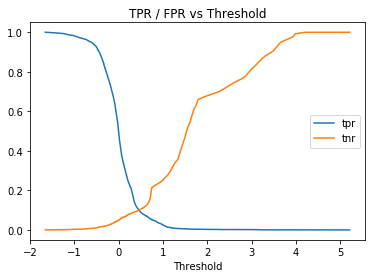

In [50]:
if not config['load']:
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / FPR vs Threshold')
    plt.legend()

In [52]:
idx1 = np.where(tpr <= tnr)[0]
idx2 = np.where(tpr >= tnr)[0]
# t = 0.5 * (thresholds[idx1[-1]] + thresholds[idx2[-1]])
# t = thresholds[idx2[-1]]
t = thresholds[idx1[-1]]
total_correct, total_examples = 0, 0
y_true, y_pred = [], []
num_batches = int(ceil(len(dataset) / config['batch_size']))
with torch.no_grad():
    for (idx, batch) in enumerate(loader):
        edges, features, node_layers, mappings, rows, labels = batch
        features, labels = features.to(device), labels.to(device)
        out = model(features, node_layers, mappings, rows)
        all_pairs = torch.mm(out, out.t())
        scores = all_pairs[edges.T]
        predictions = (scores >= t).long()
        y_true.extend(labels.detach().numpy())
        y_pred.extend(predictions.detach().numpy())
        total_correct += torch.sum(predictions == labels.long()).item()
        total_examples += len(labels) 
        print('    Batch {} / {}'.format(idx+1, num_batches))
print('threshold: {}, accuracy: {}'.format(t, total_correct / total_examples))
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()
report = classification_report(y_true, y_pred)
print(report)

    Batch 1 / 248
    Batch 2 / 248
    Batch 3 / 248
    Batch 4 / 248
    Batch 5 / 248
    Batch 6 / 248
    Batch 7 / 248
    Batch 8 / 248
    Batch 9 / 248
    Batch 10 / 248
    Batch 11 / 248
    Batch 12 / 248
    Batch 13 / 248
    Batch 14 / 248
    Batch 15 / 248
    Batch 16 / 248
    Batch 17 / 248
    Batch 18 / 248
    Batch 19 / 248
    Batch 20 / 248
    Batch 21 / 248
    Batch 22 / 248
    Batch 23 / 248
    Batch 24 / 248
    Batch 25 / 248
    Batch 26 / 248
    Batch 27 / 248
    Batch 28 / 248
    Batch 29 / 248
    Batch 30 / 248
    Batch 31 / 248
    Batch 32 / 248
    Batch 33 / 248
    Batch 34 / 248
    Batch 35 / 248
    Batch 36 / 248
    Batch 37 / 248
    Batch 38 / 248
    Batch 39 / 248
    Batch 40 / 248
    Batch 41 / 248
    Batch 42 / 248
    Batch 43 / 248
    Batch 44 / 248
    Batch 45 / 248
    Batch 46 / 248
    Batch 47 / 248
    Batch 48 / 248
    Batch 49 / 248
    Batch 50 / 248
    Batch 51 / 248
    Batch 52 / 248
    Batch 53 / 248
  

In [58]:
if config['load']:
    directory = os.path.join(os.path.dirname(os.getcwd()),
                             'trained_models')
    fname = utils.get_fname(config)
    path = os.path.join(directory, fname)
    model.load_state_dict(torch.load(path))
dataset_args = (config['task'], config['dataset'], config['dataset_path'],
                config['neg_examples_path'], 'train',
                config['num_layers'], config['self_loop'],
                config['normalize_adj'])
dataset = utils.get_dataset(dataset_args)
loader = DataLoader(dataset=dataset, batch_size=config['batch_size'],
                    shuffle=False, collate_fn=dataset.collate_wrapper)
criterion = utils.get_criterion(config['task'])
stats_per_batch = config['stats_per_batch']
num_batches = int(ceil(len(dataset) / config['batch_size']))
model.eval()
print('--------------------------------')
print('Testing.')
running_loss, total_loss = 0.0, 0.0
num_correct, num_examples = 0, 0
total_correct, total_examples = 0, 0
y_true, y_scores = [], []
for (idx, batch) in enumerate(loader):
    edges, features, node_layers, mappings, rows, labels = batch
    features, labels = features.to(device), labels.to(device)
    out = model(features, node_layers, mappings, rows)
    all_pairs = torch.mm(out, out.t())
    scores = all_pairs[edges.T]
    loss = criterion(scores, labels.float())
    running_loss += loss.item()
    total_loss += loss.item()
    predictions = (scores >= t).long()
    num_correct += torch.sum(predictions == labels.long()).item()
    total_correct += torch.sum(predictions == labels.long()).item()
    num_examples += len(labels)
    total_examples += len(labels)
    y_true.extend(labels.detach().numpy())
    y_scores.extend(scores.detach().numpy())
    if (idx + 1) % stats_per_batch == 0:
        running_loss /= stats_per_batch
        accuracy = num_correct / num_examples
        area = roc_auc_score(labels.detach().numpy(), scores.detach().numpy())
        print('    Batch {} / {}: loss {}, accuracy {}'.format(
            idx+1, num_batches, running_loss, accuracy))
        print('    ROC-AUC score: {}'.format(area))
        running_loss = 0.0
        num_correct, num_examples = 0, 0
total_loss /= num_batches
total_accuracy = total_correct / total_examples
print('Loss {}, accuracy {}'.format(total_loss, total_accuracy))
y_true = np.array(y_true).flatten()
y_scores = np.array(y_scores).flatten()
area = roc_auc_score(y_true, y_scores)
print('ROC-AUC score: {}'.format(area))
print('Finished testing.')
print('--------------------------------')

--------------------------------
Reading CollegeMsg dataset from /Users/raunak/Documents/Datasets/temporal-networks-snap/CollegeMsg.txt
Finished reading data.
Setting up data structures.
Finished setting up data structures.
Setting up examples.
Finished setting up examples.
--------------------------------
--------------------------------
Testing.
    Batch 3 / 248: loss 0.4930980900923411, accuracy 0.9166666666666666
    ROC-AUC score: 0.9444444444444444
    Batch 6 / 248: loss 0.44799428184827167, accuracy 0.90625
    ROC-AUC score: 0.9529411764705882
    Batch 9 / 248: loss 0.4564826488494873, accuracy 0.875
    ROC-AUC score: 0.9285714285714286
    Batch 12 / 248: loss 0.501114030679067, accuracy 0.90625
    ROC-AUC score: 0.9801587301587302
    Batch 15 / 248: loss 0.47460023562113446, accuracy 0.8541666666666666
    ROC-AUC score: 0.9490196078431372
    Batch 18 / 248: loss 0.487228920062383, accuracy 0.90625
    ROC-AUC score: 1.0
    Batch 21 / 248: loss 0.5528845191001892, acc

    Batch 228 / 248: loss 0.5214638014634451, accuracy 0.8958333333333334
    ROC-AUC score: 0.7125506072874495
    Batch 231 / 248: loss 0.46113114555676776, accuracy 0.9583333333333334
    ROC-AUC score: 0.9958333333333333
    Batch 234 / 248: loss 0.5070223112901052, accuracy 0.8958333333333334
    ROC-AUC score: 0.9880952380952381
    Batch 237 / 248: loss 0.4411312937736511, accuracy 0.875
    ROC-AUC score: 0.9624999999999999
    Batch 240 / 248: loss 0.47854315241177875, accuracy 0.90625
    ROC-AUC score: 0.9843137254901961
    Batch 243 / 248: loss 0.505590945482254, accuracy 0.8854166666666666
    ROC-AUC score: 0.9882352941176471
    Batch 246 / 248: loss 0.4858866532643636, accuracy 0.9166666666666666
    ROC-AUC score: 0.95
Loss 0.4791728828943545, accuracy 0.9019459186252211
ROC-AUC score: 0.9369781890220044
Finished testing.
--------------------------------
